# sprint 深層学習スクラッチ ディープニューラルネットワーク

# ディープニューラルネットワークスクラッチ

前回は3層のニューラルネットワークを作成しましたが、今回はこれを任意の層数に拡張しやすいものに書き換えていきます。その上で、活性化関数や初期値、最適化手法について発展的なものを扱えるようにしていきます。


このようなスクラッチを行うことで、今後各種フレームワークを利用していくにあたり、内部の動きが想像できることを目指します。


名前は新しくScratchDeepNeuralNetrowkClassifierクラスとしてください。

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## 層などのクラス化
クラスにまとめて行くことで、構成を変更しやすい実装にしていきます。


手を加える箇所


* 層の数
* 層の種類（今後畳み込み層など他のタイプの層が登場する）
* 活性化関数の種類
* 重みやバイアスの初期化方法
* 最適化手法

そのために、全結合層、各種活性化関数、重みやバイアスの初期化、最適化手法それぞれのクラスを作成します。


実装方法は自由ですが、簡単な例を紹介します。サンプルコード1のように全結合層と活性化関数のインスタンスを作成し、サンプルコード2,3のようにして使用します。それぞれのクラスについてはこのあと解説します。

In [89]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
    def __len__(self):
        return self._stop
    
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    
    def __iter__(self):
        self._counter = 0
        return self
    
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [567]:
class ScratchDeepNeuralNetrowkClassifier():
    """
    DNNスクラッチ
    Parameters
    ----------
    epoch_count : int
      エポック回数
    layer_act : dic
      layerとact名
    n_nodes : タプル int
      各ノードの数
    lr : int
      学習率
    activation : obj
      活性化手法のインスタンス
    layer_type : obj
      層のインスタンス
    initializer : obj
      初期化方法のインスタンス
    optimizer : obj
      最適化手法のインスタンス
    sigma : float
      標準偏差、SimpleInitializerのみ入力
    layer_dic : dic
      key : layer名、value : 層のインスタンス
    act_dic : dic
      key : activation名、value : activationのインスタンス
    train_loss : list
      trainのエポック毎のcross_entropyを格納するリスト(エポック毎の平均値)
    val_loss : list
      valのエポック毎のcross_entropyを格納するリスト(全データ分を計算)
    n_features : int
      特徴量の数
    n_output : int
      出力層のノード数
    """
    def __init__(self, epoch_count, layer_act, n_nodes, lr, layer_type, activation, initializer, optimizer, sigma=None):
        self.epoch_count = epoch_count
        self.n_nodes = n_nodes
        self.lr = lr
        self.sigma = sigma
        self.layer_type = layer_type
        self.activation = activation
        self.initializer = initializer
        self.optimizer = optimizer
        self.layer_dic = {}
        self.act_dic = {}
        self.train_loss = []
        self.val_loss = []
        
    def fit(self, X, y, X_val=None, y_val=None):
        # 初期化
        ini_sigma = self.sigma
        n_features = X.shape[1]
        n_output = y.shape[1]
        # 特徴量の数、各ノード数、出力ノード数を結合
        self.n_nodes = list(self.n_nodes)
        self.n_nodes.insert(0, n_features)
        self.n_nodes.append(n_output)
        # 層の数だけインスタンス化、リストに追加
        num = 0
        nodes_num = len(self.n_nodes) - 1
        for layer, act in layer_act.items():
            # インスタンス時にsigma設定しない場合(AdaGrad)、前のノード数を代入する
            self.sigma = self.n_nodes[num] if ini_sigma is None else ini_sigma
            self.layer_dic[layer] = self.layer_type(self.n_nodes[num], self.n_nodes[num+1], self.initializer(self.sigma), self.optimizer(self.lr))
            # 出力時のみactはSoftmax
            if num+1 == nodes_num:
                self.act_dic[act] = Softmax()
            else:
                self.act_dic[act] = self.activation()
            num += 1
            
        # ミニバッチのインスタンス
        get_mini_batch = GetMiniBatch(X, y, batch_size=20)
        
        # エポック回数繰り返し
        for epoch in range(self.epoch_count):
            # イテレーション回数の初期化
            iter_count = 1
            # イテレーション毎のloss(cross_entropy)記録用array初期化
            train_loss = np.zeros(len(get_mini_batch))
            # イテレーション回数繰り返し
            for mini_X, mini_y in get_mini_batch:
                # 回数の表示
                if iter_count%2400 == 0:
                    print("エポック{}".format(epoch+1))
                    print("{}回目の学習".format(iter_count))
                # 層の数だけforward
                # 処理回数の初期化
                num = 0
                for layer, act in zip(self.layer_dic.values(), self.act_dic.values()):
                    if num==0:
                        Z = mini_X
                    A = layer.forward(Z)
                    Z = act.forward(A)
                    num += 1
                    
                # 層の数だけbackward(降順)
                # 逆順用の辞書を作成
                layer_dic_re = {}
                act_dic_re = {}
                for key, item in sorted(self.layer_dic.items(), reverse=True):
                    layer_dic_re[key] = item
                for key, item in sorted(self.act_dic.items(), reverse=True):
                    act_dic_re[key] = item
                # 処理回数の初期化   
                num = 0
                for layer, act in zip(layer_dic_re.values(), act_dic_re.values()):
                    if num==0:
                        # 交差エントロピー誤差とソフトマックスを合わせている
                        dA, train_L = act.backward(mini_y)
                    else:
                        dA = act.backward(dZ)
                    dZ = layer.backward(dA)
                    num += 1   
                # イテレーション毎のloss(cross_entropy)記録
                train_loss[iter_count-1] = train_L
                # イテレーション回数のカウント
                iter_count += 1
             
            # valのlossを計算
            # valのforward
            num = 0
            for layer, act in zip(self.layer_dic.values(), self.act_dic.values()):
                if num==0:
                    Z = X_val
                A = layer.forward(Z)
                Z = act.forward(A)
                # valのcross_entropy計算
                if num+1 == nodes_num:
                    dA, val_L = act.backward(y_val)
                num += 1
            
            # loss(cross_entropy)記録
            self.train_loss.append(train_loss.mean())
            self.val_loss.append(val_L)
        
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        num = 0
        for layer, act in zip(self.layer_dic.values(), self.act_dic.values()):
            if num==0:
                Z = X
            A = layer.forward(Z)
            Z = act.forward(A)
            num += 1
        
        return Z.argmax(axis=1)

# 【問題1】全結合層のクラス化
全結合層のクラス化を行なってください。


以下に雛形を載せました。コンストラクタで重みやバイアスの初期化をして、あとはフォワードとバックワードのメソッドを用意します。重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、煩雑な入出力は不要になります。


なお、インスタンスも引数として渡すことができます。そのため、初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われます。渡すインスタンスを変えれば、初期化方法が変えられます。


また、引数として自身のインスタンスselfを渡すこともできます。これを利用してself.optimizer.update(self)という風に層の重みの更新が可能です。更新に必要な値は複数ありますが、全て全結合層が持つインスタンス変数にすることができます。

In [576]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.initializer = initializer
        self.W = self.initializer.W(n_nodes1, n_nodes2)
        self.B = self.initializer.B(n_nodes2)
        # 初期値
        self.Z = None
        #  AdaGrad用の変数
        self.H_B = 0
        self.H_W = 0
            
    def forward(self, Z):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        # backward用に保持
        self.Z = Z
        # forwardの計算
        Z = np.concatenate([np.ones([self.Z.shape[0], 1]), self.Z], axis=1)
        W_baias = np.concatenate([self.B, self.W], axis=0)
        A = Z.dot(W_baias)
        
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # backwardの計算
        dB = dA.sum(axis=0)
        dW = self.Z.T.dot(dA)
        dZ = dA.dot(self.W.T)
        
        #  AdaGrad用の計算
        size = dA.shape[0]
        self.H_B += (dB/size)**2
        self.H_W += (dW/size)**2
        
        # 更新(AdaGrad用に引数を設定)
        self.B, self.W = self.optimizer.update(self.B, self.W, dB, dW, self.H_B, self.H_W, size)
        
        return dZ

# 問題2】初期化方法のクラス化
初期化を行うコードをクラス化してください。


前述のように、全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにします。以下の雛形に必要なコードを書き加えていってください。標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむようになります。


これまで扱ってきた初期化方法はSimpleInitializerクラスと名付けることにします。

In [314]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

# 【問題3】最適化手法のクラス化
最適化手法のクラス化を行なってください。


最適化手法に関しても初期化方法同様に全結合層にインスタンスとして渡します。バックワードのときにself.optimizer.update(self)のように更新できるようにします。以下の雛形に必要なコードを書き加えていってください。


これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成します。

In [562]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        # AdaGrad用に引数を設定
    def update(self, B, W, dB, dW, H_B=None, H_W=None, size=None):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        """
        
        B -=self.lr*dB/dA.shape[0]
        W -= self.lr*dW/dA.shape[0]
        
        return B, W

# 【問題4】活性化関数のクラス化
活性化関数のクラス化を行なってください。


ソフトマックス関数のバックプロパゲーションには交差エントロピー誤差の計算も含む実装を行うことで計算が簡略化されます。

In [563]:
class Tanh:
    
    def __init__(self):
        self.A = None
    
    def forward(self, A):
        # backward用に保持
        self.A = A
        # forward計算
        Z = np.tanh(A)
        return Z
    
    def backward(self, dZ):
        dA = dZ * (1 - (np.tanh(self.A))**2)
        return dA

In [564]:
class Softmax:
    
    def __init__(self):
        self.Z = None
    
    def forward(self, A):
        # forward計算
        Z = np.exp(A)/(np.exp(A).sum(axis=1).reshape([-1, 1]))
        # backward用に保持
        self.Z = Z
        return Z
        
    def backward(self, y):
        # backward
        dA = self.Z - y
        # cross_entropy
        L = -(y*np.log(self.Z)).sum()/y.shape[0]
        return dA, L

# 【問題5】ReLUクラスの作成
現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装してください。


ReLUは以下の数式です。

In [565]:
class ReLU:
    
    def __init__(self):
        self.A = None
    
    def forward(self, A):
        # backward用に保持
        self.A = A
        # forward計算
        Z = np.maximum(0, A)
        return Z
   
    def backward(self, dZ):
        dA = dZ*(np.where(self.A>0, 1,0))
        return dA

# 【問題6】重みの初期値
ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきました。しかし、どのような値にすると良いかが知られています。シグモイド関数やハイパボリックタンジェント関数のときは Xavierの初期値 （またはGlorotの初期値）、ReLUのときは Heの初期値 が使われます。


XavierInitializerクラスと、HeInitializerクラスを作成してください。

In [568]:
class Xavier:
    """
    Xavierの初期化
    Parameters
    ----------
    sigma : float
      Xavierの標準偏差
    """
    def __init__(self, n_nodes1):
        # ScratchDeepNeuralNetrowkClassifierでは変数名sigmaとしてn_nodes1を受け取っている
        self.sigma = np.sqrt(1/n_nodes1)
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

In [571]:
class He:
    """
    Heの初期化
    Parameters
    ----------
    sigma : float
      Heの標準偏差
    """
    def __init__(self, n_nodes1):
        # ScratchDeepNeuralNetrowkClassifierでは変数名sigmaとしてn_nodes1を受け取っている
        self.sigma = np.sqrt(2/n_nodes1)
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

# 【問題7】最適化手法
学習率は学習過程で変化させていく方法が一般的です。基本的な手法である AdaGrad のクラスを作成してください。


まず、これまで使ってきたSGDを確認します。

In [574]:
class AdaGrad:
    """
    AdaGrad
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, B, W, dB, dW, H_B, H_W, size=None):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        """ 
        B -= self.lr*dB/size/(np.sqrt(H_B) + 1E-1)
        W -= self.lr*dW/size/(np.sqrt(H_W) + 1E-1)
        
#         print("adagrad")
#         print("dB", dB)
#         print("H_B", H_B)
#         print("np.sqrt(H_B)", np.sqrt(H_B))
#         print("dW", dW)
#         print("H_W", H_W)
#         print("np.sqrt(H_W)", np.sqrt(H_W))
#         print("adagrad", )
#         print("", )
        
        return B, W

# 【問題8】クラスの完成
任意の構成で学習と推定が行えるScratchDeepNeuralNetrowkClassifierクラスを完成させてください。

# 【問題9】学習と推定
層の数や活性化関数を変えたいくつかのネットワークを作成してください。そして、MNISTのデータを学習・推定し、Accuracyを計算してください。

In [531]:
# データロード
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 平滑化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# 正規化
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

#分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# one_hot化
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.fit_transform(y_val[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

In [552]:
# RelU, He, AdaGrad
layer_act = {"FC1":"ACT1", "FC2":"ACT2", "FC3":"ACT3"}
sdnn = ScratchDeepNeuralNetrowkClassifier(epoch_count=10, layer_act=layer_act, n_nodes=(400, 200), lr=0.01,
                                          layer_type=FC, activation=ReLU, initializer=He, optimizer=AdaGrad, sigma=None)
sdnn.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

エポック1
2400回目の学習
エポック2
2400回目の学習
エポック3
2400回目の学習
エポック4
2400回目の学習
エポック5
2400回目の学習
エポック6
2400回目の学習
エポック7
2400回目の学習
エポック8
2400回目の学習
エポック9
2400回目の学習
エポック10
2400回目の学習


正解率：0.9759166666666667


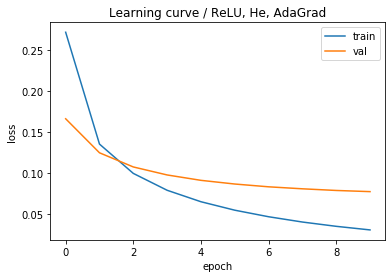

In [553]:
# 推定　→　Accuracy
y_pred = sdnn.predict(X_val)
print("正解率：{}".format(accuracy_score(y_val, y_pred)))
# 学習曲線
plt.plot(sdnn.train_loss, label='train')
plt.plot(sdnn.val_loss, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Learning curve / ReLU, He, AdaGrad')
plt.legend()
plt.show()

In [554]:
# ReLU, He, SGD
layer_act = {"FC1":"ACT1", "FC2":"ACT2", "FC3":"ACT3"}
sdnn_relu_sgd = ScratchDeepNeuralNetrowkClassifier(epoch_count=10, layer_act=layer_act, n_nodes=(400, 200), lr=0.01,
                                          layer_type=FC, activation=ReLU, initializer=He, optimizer=SGD, sigma=None)
sdnn_relu_sgd.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

エポック1
2400回目の学習
エポック2
2400回目の学習
エポック3
2400回目の学習
エポック4
2400回目の学習
エポック5
2400回目の学習
エポック6
2400回目の学習
エポック7
2400回目の学習
エポック8
2400回目の学習
エポック9
2400回目の学習
エポック10
2400回目の学習


正解率：0.9799166666666667


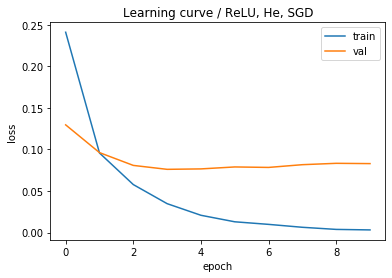

In [555]:
# 推定　→　Accuracy
y_pred = sdnn_relu_sgd.predict(X_val)
print("正解率：{}".format(accuracy_score(y_val, y_pred)))
# 学習曲線
plt.plot(sdnn_relu_sgd.train_loss, label='train')
plt.plot(sdnn_relu_sgd.val_loss, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Learning curve / ReLU, He, SGD')
plt.legend()
plt.show()

In [534]:
# Tanh, Xavier, AdaGrad
layer_act = {"FC1":"ACT1", "FC2":"ACT2", "FC3":"ACT3"}
sdnn_tanh = ScratchDeepNeuralNetrowkClassifier(epoch_count=10, layer_act=layer_act, n_nodes=(400, 200), lr=0.01,
                                          layer_type=FC, activation=Tanh, initializer=Xavier, optimizer=AdaGrad, sigma=None)
sdnn_tanh.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

エポック1
2400回目の学習
エポック2
2400回目の学習
エポック3
2400回目の学習
エポック4
2400回目の学習
エポック5
2400回目の学習
エポック6
2400回目の学習
エポック7
2400回目の学習
エポック8
2400回目の学習
エポック9
2400回目の学習
エポック10
2400回目の学習


正解率：0.9676666666666667


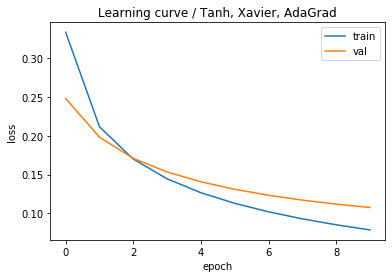

In [537]:
# 推定　→　Accuracy
y_pred = sdnn_tanh.predict(X_val)
print("正解率：{}".format(accuracy_score(y_val, y_pred)))
# 学習曲線
plt.plot(sdnn_tanh.train_loss, label='train')
plt.plot(sdnn_tanh.val_loss, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Learning curve / Tanh, Xavier, AdaGrad')
plt.legend()
plt.show()

In [544]:
# Tanh, Xavier, SGD
layer_act = {"FC1":"ACT1", "FC2":"ACT2", "FC3":"ACT3"}
sdnn_tanh_sgd = ScratchDeepNeuralNetrowkClassifier(epoch_count=10, layer_act=layer_act, n_nodes=(400, 200), lr=0.01,
                                          layer_type=FC, activation=Tanh, initializer=Xavier, optimizer=SGD, sigma=None)
sdnn_tanh_sgd.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

エポック1
2400回目の学習
エポック2
2400回目の学習
エポック3
2400回目の学習
エポック4
2400回目の学習
エポック5
2400回目の学習
エポック6
2400回目の学習
エポック7
2400回目の学習
エポック8
2400回目の学習
エポック9
2400回目の学習
エポック10
2400回目の学習


正解率：0.976


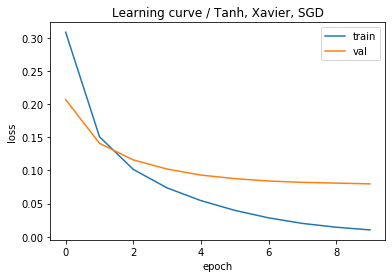

In [545]:
# 推定　→　Accuracy
y_pred = sdnn_tanh_sgd.predict(X_val)
print("正解率：{}".format(accuracy_score(y_val, y_pred)))
# 学習曲線
plt.plot(sdnn_tanh_sgd.train_loss, label='train')
plt.plot(sdnn_tanh_sgd.val_loss, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Learning curve / Tanh, Xavier, SGD')
plt.legend()
plt.show()